### Analysis for Crash blog post
This notebook contains code for extracting recent crash data and analyzing according to the blog post

In [ ]:
import requests
from datetime import datetime

# this is the source for the crash data
# https://data.boston.gov/dataset/vision-zero-crash-records/resource/e4bfe397-6bfc-49c5-9367-c879fac7401d
resource_id = 'e4bfe397-6bfc-49c5-9367-c879fac7401d'

def call_api(url):
  response = requests.get(url)
  if response.status_code == 200:
    data = response.json()
    return data['result']['records']
  else:
    print(f"Error: {response.status_code}")
    print(response.text)
    return None

# iterate for past three years
# TODO: only necessary for a full refresh, can do incremental updates in the future
# limit for sql queries is hard-coded to 32001 - if year greater than that, need a better approach
cur_year = datetime.now().year
past_years = 5
collect_records = []
for year in range(cur_year-past_years, cur_year+1):
  print(year)
  st_date = f'{year}-01-01'
  end_date = f'{year+1}-01-01'
  sql = f"""SELECT dispatch_ts, mode_type, location_type, street, xstreet1, xstreet2, lat, long 
  from "{resource_id}" 
  WHERE dispatch_ts>='{st_date}' and dispatch_ts<'{end_date}'"""
  url = f"https://data.boston.gov/api/3/action/datastore_search_sql?sql={sql}"
  result = call_api(url)
  if result:
    collect_records.extend(result)

In [6]:
# write to file
print(f"Total records: {len(collect_records)}")
with open('data/crash_records.csv', 'w') as f:
  f.write('dispatch_ts,mode_type,location_type,street,xstreet1,xstreet2,lat,long\n')
  for record in collect_records:
    f.write(','.join([str(record[key]) for key in ['dispatch_ts', 'mode_type', 'location_type', 'street', 'xstreet1', 'xstreet2', 'lat', 'long']]) + '\n')



Total records: 19096


,dispatch_ts,mode_type,location_type,street,xstreet1,xstreet2,lat,long
0,2019-04-29 15:34:41+00,mv,Other,NaN,NaN,NaN,42.339941,-71.063874
1,2019-05-03 16:32:32+00,mv,Other,NaN,NaN,NaN,42.329404,-71.060470
2,2019-05-22 16:44:51+00,mv,Other,NaN,NaN,NaN,42.347594,-71.085586
3,2019-06-24 08:37:03+00,mv,Other,NaN,NaN,NaN,42.339941,-71.063874
4,2019-06-25 14:18:05+00,mv,Other,NaN,NaN,NaN,42.366334,-71.060410


In [2]:
# process records into geodataframe
import geopandas as gpd
import pandas as pd

df = gpd.GeoDataFrame(pd.read_csv('data/crash_records.csv'))
df.set_geometry(gpd.points_from_xy(df.long, df.lat), inplace=True)
# collect mode types
mode_types = df['mode_type'].unique()
for m in mode_types:
    print(m)
    m_df = df[df.mode_type == m]
    print(m_df.shape)
    # group by geometry, get string of dates
    m_df = m_df.groupby('geometry').agg({'dispatch_ts':[lambda x: ','.join(x),
                                                    pd.Series.nunique,]}).reset_index()
    # rename
    m_df.columns = ['geometry', 'crash_dates', 'total_crashes']
    m_df = gpd.GeoDataFrame(m_df)
    m_df.to_file(f"./data/{m}_rollup.geojson", driver='GeoJSON')

mv
(15010, 9)
ped
(2497, 9)
bike
(1589, 9)


In [3]:
# # keeping - some strangely high numbers with a specific geocode
# maybe defaults?
# max_id = df.groupby('geometry').size().sort_values().index[-]
# # lookup max_id geometry
# df[df.geometry == max_id]

In [4]:
# read in for posterity
df = pd.read_csv('data/crash_records.csv')

/var/folders/_k/42sqpt052kz96fmjll5__xxw0000gn/T/ipykernel_1667/2206134469.py:4: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['month_year'] = df['dispatch_ts'].dt.to_period('M')


<Axes: xlabel='month_year'>

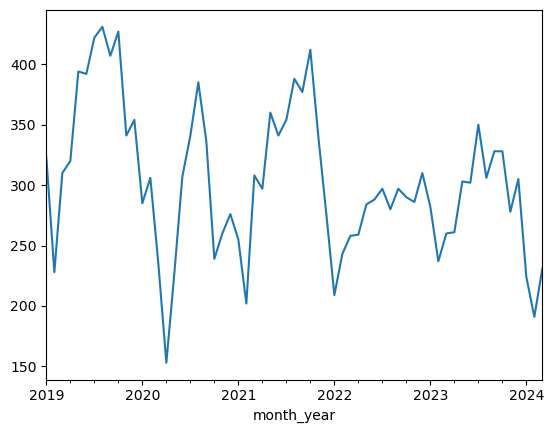

In [5]:
# look at crashes per month-year
# convert to datetime
df['dispatch_ts'] = pd.to_datetime(df['dispatch_ts'])
df['month_year'] = df['dispatch_ts'].dt.to_period('M')
#df['month_year'] = df['month_year'].astype(str)
# group by month-year
df.groupby('month_year').size().plot()


In [6]:
# this seems odd - why would the crashes drop suddenly January 2022?
df[df.month_year == '2023-1'].shape

(282, 9)

year
2019    4349
2020    3350
2021    3910
2022    3301
2023    3540
2024     646
dtype: int64
0.07240230233262648


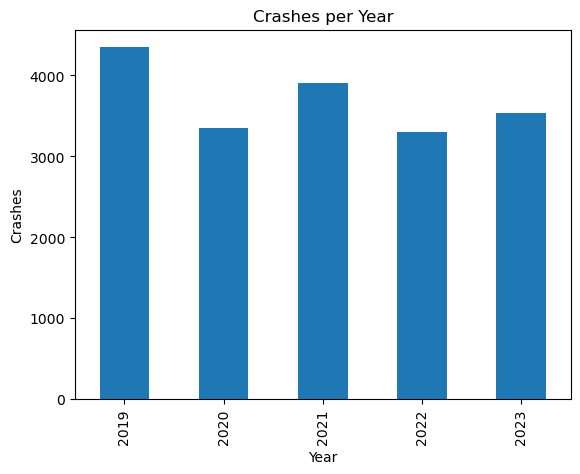

In [10]:
# look at crashes per year
# convert to datetime
df['year'] = df['dispatch_ts'].dt.year
# group by month-year
g_df = df.groupby('year').size()
ax = g_df.loc[2019:2023].plot(kind='bar')
# add labels
ax.set_ylabel('Crashes')
ax.set_xlabel('Year')
ax.set_title('Crashes per Year')
print(g_df)
print((g_df[2023]-g_df[2022])/g_df[2022])

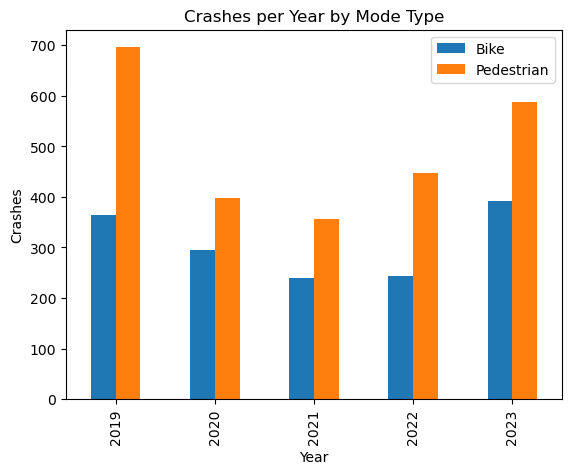

In [11]:
# break this down by mode type
ax = df.groupby(['year', 'mode_type']).size().unstack().loc[2019:2023, ['bike', 'ped']].plot(kind='bar')
# add labels
ax.set_ylabel('Crashes')
ax.set_xlabel('Year')
ax.set_title('Crashes per Year by Mode Type')
ax.legend(title='Travel mode')
ax.legend(['Bike', 'Pedestrian'])

In [14]:
# is type street - then has street populated
# if type intersection - then has xstreet1 and xstreet2 populated
df[df['street'].isnull()].location_type.value_counts()
df[df['xstreet1'].isnull()].location_type.value_counts()
# street - some null in cross?
null_x = df[(df['location_type'] == 'Street') & (df['xstreet1'].isnull())]
null_x['street'].value_counts()


street
INTERSTATE 93                      620
I93                                186
MASSACHUSETTS TPKE                 123
JAMES J STORROW MEMORIAL DR         53
I90                                 28
                                  ... 
DUDLEY ST                            1
NORFOLK ST                           1
RAMP - RT 93 NB TO RT 90 (RAMP       1
COLUMBUS AVE                         1
AMERICAN LEGION HWY                  1
Name: count, Length: 74, dtype: int64

In [15]:
# read in shapes of boston neighborhoods
neigh = gpd.read_file('/Users/bpben/Documents/crash_map/Boston_Neighborhoods_StatAreas 2017/Boston_Neighborhoods.shp')
# collect points within neighborhoods
geo_df = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.long, df.lat))
geo_df.set_crs(neigh.crs, inplace=True)
neigh_crashes = gpd.sjoin(geo_df, neigh, predicate='within')
# looks like it works!
#neigh_crashes.iloc[0].to_dict()

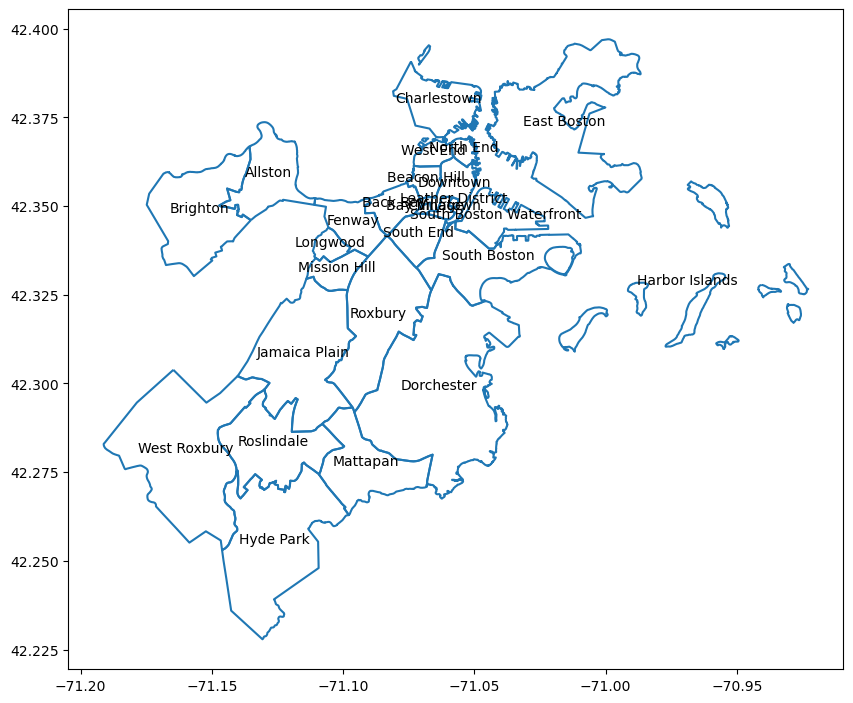

In [16]:
# plot polygons in neigh with labels
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 10))
neigh.boundary.plot(ax=ax)
neigh.apply(lambda x: ax.annotate(text=x.Name, xy=x.geometry.centroid.coords[0], ha='center'), axis=1);

Text(0.5, 0, 'Crashes per sq mile')

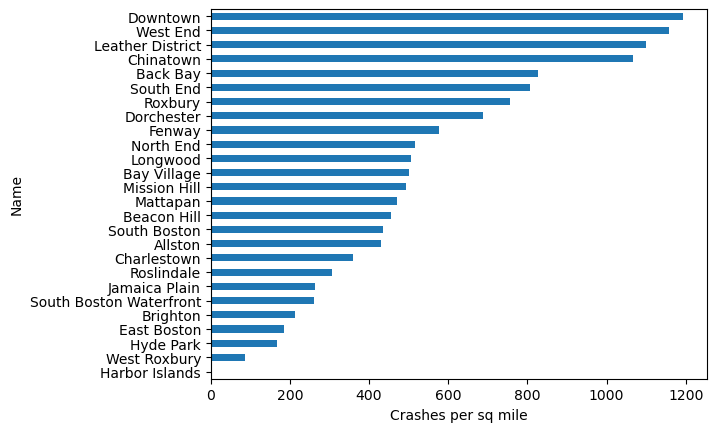

In [17]:
# group by neighborhood
crash_by_n = neigh_crashes.groupby('Name').size().sort_values()
crash_by_n.name = 'crashes'
# normalize crashes by sqmiles
norm_crash = pd.concat([crash_by_n, 
           neigh.set_index('Name').SqMiles], axis=1).sort_values('crashes', ascending=False)
norm_crash['crash_per_sqmile'] = norm_crash['crashes'] / norm_crash['SqMiles']
# plot 
ax = norm_crash.sort_values('crash_per_sqmile').crash_per_sqmile.plot(kind='barh')
# add labels
ax.set_xlabel('Crashes per sq mile')

Text(0.5, 0, 'Crashes per 1,000 residents')

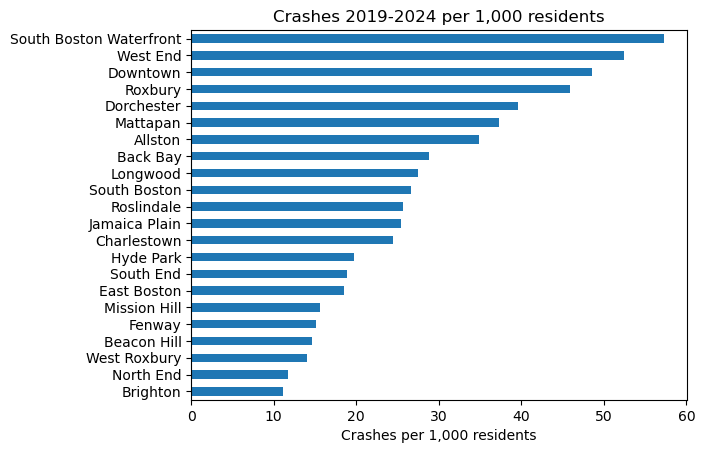

In [20]:
# probably more sensible to have population-normalized
pop_df = pd.read_excel('./data/2015-2019_neighborhood_tables_2021.12.21.xlsm')
pop_df = pop_df.iloc[3:, :2]
pop_df.columns = ['Name', 'population']
pop_df = pop_df.set_index('Name').dropna()
# annoying processing
pop_df.index = pop_df.index.str.strip()
pop_df = pop_df[pop_df.index.isin(norm_crash.index)]
pop_norm_crash = pd.concat([norm_crash, pop_df], axis=1)
# Bay Village is part of South End
pop_norm_crash.loc['South End', 'crashes'] += pop_norm_crash.loc['Bay Village', 'crashes']
pop_norm_crash.drop('Bay Village', inplace=True)
# Chinatown and Leather District is part of Downtown
pop_norm_crash.loc['Downtown', 'crashes'] += pop_norm_crash.loc['Chinatown', 'crashes']
pop_norm_crash.drop('Chinatown', inplace=True)
pop_norm_crash.loc['Downtown', 'crashes'] += pop_norm_crash.loc['Leather District', 'crashes']
pop_norm_crash.drop('Leather District', inplace=True)
# drop harbor islands, it's paradise there
pop_norm_crash.drop('Harbor Islands', inplace=True)
pop_norm_crash['crash_per_1000'] = pop_norm_crash['crashes'] / pop_norm_crash['population'] * 1000
ax = pop_norm_crash.sort_values('crash_per_1000').crash_per_1000.plot(kind='barh')
ax.set_title('Crashes 2019-2024 per 1,000 residents')
ax.set_ylabel('')
ax.set_xlabel('Crashes per 1,000 residents')

In [21]:
# check my work
sample = pop_df.iloc[0]
print(sample)
print(pop_norm_crash.loc[sample.name, 'crashes'])
print(pop_norm_crash.loc[sample.name, 'crashes']/sample.values[0] * 1000)
print(pop_norm_crash.loc[sample.name])

population    19261
Name: Allston, dtype: object
672
34.889154249519756
crashes                    672
SqMiles                   1.56
crash_per_sqmile    430.769231
population               19261
crash_per_1000       34.889154
Name: Allston, dtype: object


Text(0.5, 0, 'Proportion Change')

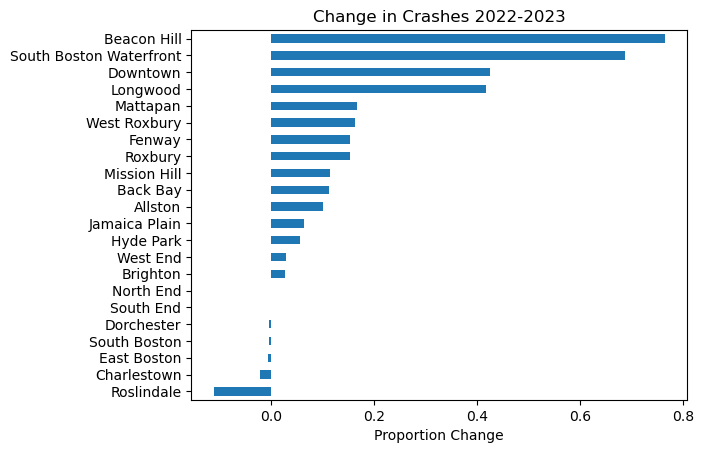

In [25]:
# look at the differences 2022 to 2023
# same plot as above, show pctage change
crash_by_n_y = neigh_crashes.groupby(['Name', 'year']).size().sort_values()
crash_by_n_y.name = 'crashes'
p_d_crash = crash_by_n_y.unstack(level=1)[[2022, 2023]].diff(axis=1).iloc[:, 1]

# Bay Village is part of South End
p_d_crash.loc['South End'] += p_d_crash.loc['Bay Village']
p_d_crash.drop('Bay Village', inplace=True)
# Chinatown and Leather District is part of Downtown
p_d_crash.loc['Downtown'] += p_d_crash.loc['Chinatown']
p_d_crash.drop('Chinatown', inplace=True)
p_d_crash.loc['Downtown'] += p_d_crash.loc['Leather District']
p_d_crash.drop('Leather District', inplace=True)
p_d_crash = (p_d_crash/crash_by_n_y.unstack(level=1)[2022])
p_d_crash.dropna(inplace=True)
ax = p_d_crash.sort_values().plot(kind='barh')
ax.set_title('Change in Crashes 2022-2023')
ax.set_ylabel('')
ax.set_xlabel('Proportion Change')

In [105]:
# check my work
sample = crash_by_n_y.loc[('Allston'), [2022, 2023]]
sample.diff().iloc[-1] / crash_by_n_y.loc[('Allston'), [2022]]

Name     year
Allston  2022    0.100775
Name: crashes, dtype: float64

year
2019    861
2020    826
2021    765
2022    710
2023    779
2024    646
dtype: int64
-0.17073170731707318


Text(0.5, 1.0, 'Crashes per Year 2019-2024, first 3 months')

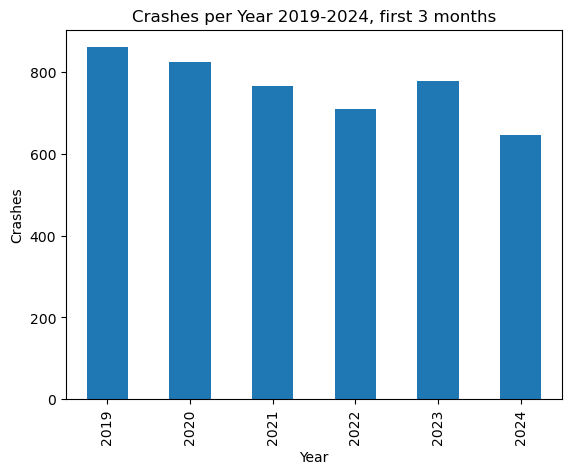

In [28]:
# is 2024 showing signs of continuity with this pattern?
max_month = df.month_year.max().month
less_max_month = df[df.dispatch_ts.dt.month<=max_month]
g_less = less_max_month.groupby('year').size()
ax = g_less.loc[2019:2024].plot(kind='bar')
print(g_less)
print((g_less.loc[2024]-g_less.loc[2023])/g_less.loc[2023])
# add labels
ax.set_ylabel('Crashes')
ax.set_xlabel('Year')
ax.set_title(f'Crashes per Year 2019-2024, first {max_month} months')

mode_type  bike  ped
year                
2019         44  161
2020         41  125
2021         23   70
2022         30   94
2023         33  149
2024         56   11
0.696969696969697


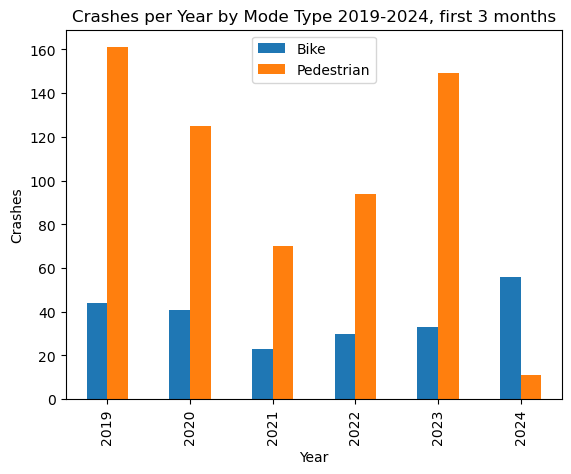

In [29]:
# break this down by mode type
g_less_mode = less_max_month.groupby(['year', 'mode_type']).size().unstack().loc[:, ['bike', 'ped']]
ax = g_less_mode.plot(kind='bar')
print(g_less_mode)
print((g_less_mode.loc[2024, 'bike']-g_less_mode.loc[2023, 'bike'])/g_less_mode.loc[2023, 'bike'])
# add labels
ax.set_ylabel('Crashes')
ax.set_xlabel('Year')
ax.set_title(f'Crashes per Year by Mode Type 2019-2024, first {max_month} months')
ax.legend(title='Travel mode')
ax.legend(['Bike', 'Pedestrian'])


In [ ]:
pop_norm_crash = pd.concat([norm_crash, pop_df], axis=1)
# Bay Village is part of South End
pop_norm_crash.loc['South End', 'crashes'] += pop_norm_crash.loc['Bay Village', 'crashes']
pop_norm_crash.drop('Bay Village', inplace=True)
# Chinatown and Leather District is part of Downtown
pop_norm_crash.loc['Downtown', 'crashes'] += pop_norm_crash.loc['Chinatown', 'crashes']
pop_norm_crash.drop('Chinatown', inplace=True)
pop_norm_crash.loc['Downtown', 'crashes'] += pop_norm_crash.loc['Leather District', 'crashes']
pop_norm_crash.drop('Leather District', inplace=True)
# drop harbor islands, it's paradise there
pop_norm_crash.drop('Harbor Islands', inplace=True)
pop_norm_crash['crash_per_1000'] = pop_norm_crash['crashes'] / pop_norm_crash['population'] * 1000
ax = pop_norm_crash.sort_values('crash_per_1000').crash_per_1000.plot(kind='barh')
ax.set_title('Crashes 2019-2024 per 1,000 residents')
ax.set_ylabel('')
ax.set_xlabel('')